# Simulations

While `whimstan` is a primarily an interface to various Bayesian hierarchical models for fitting the afterglow spectra of GRBs, it also provides some capabilities to simulate individual XRT spectra from population distributions. We leverage the capabilities of [popsynth](https://popsynth.readthedocs.io/en/latest/) to generate the population parameters and then use [3ml](https://threeml.readthedocs.io/en/stable/) to fold synthesized spectra through the response of XRT.

All of this complexity is handled with a few simple routines.


## Components

### GRB Spectrum


The GRB intrinsic spectra are power laws (assumed to be synchrotron emission). The luminosity is drawn from a Schecter function and the redshift from a distribution [Cole]()-like shape. The photon index is sampled from a Gaussian. All of these parameters a configurable.

### Host galaxy absorbing column

The photons from the GRB first must pass through the local gas in its their host galaxy. The column density can either be simulated as a log-normal or by assuming that GRBs occur in clouds of various ellipsoidal shapes with a distribution of densities. To use the clouds in the simulation, the user specifies the mean and standard deviation of the cloud gas density [cm-3] and the minimum ratio of cloud height to radius ellipsoidal shape (z/R =1 implies a spherical cloud). These shapes are then sampled such that the ratio of the cloud follows a log-uniform distribution from spherical to the minimum ellipsoidal ratio.


In [1]:

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)

from whimstan.simulations.cloud import Cloud
import numpy as np

%matplotlib inline

[WARNING ] The naima package is not available. Models that depend on it will not be available


[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.


[WARNING ] The ebltable package is not available. Models that depend on it will not be available


[INFO    ] Starting 3ML!


[WARNING ] no display variable set. using backend for graphics without display (agg)


[WARNING ] ROOT minimizer not available


[WARNING ] Multinest minimizer not available


[WARNING ] PyGMO is not available


[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)


[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?


[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?


[WARNING ] No fermitools installed


[WARNING ] Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


[WARNING ] Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


[WARNING ] Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


Text(0.5, 0, 'nH [cm2]')

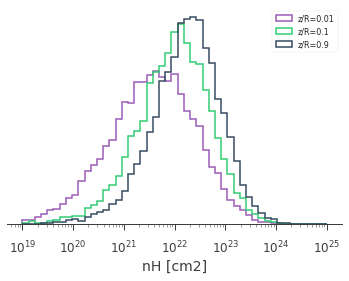

In [2]:
fig, ax = plt.subplots()

n = 10000

for min_zr in [0.01, 0.1, 0.9]:

    zr_ratio = np.power(10, np.random.uniform(np.log10(min_zr), 0, size=n))

    nh_density = np.random.normal(loc=22.5, scale=0.5, size=n)

    # create a cloud with this simulation
    clouds = [Cloud(zr_ratio=zr) for zr in zr_ratio]

    # sample the latent values for this property

    path_length = np.array([cloud.sample() for cloud in clouds])

    column_density = np.power(10.0, nh_density) * path_length

    bins = np.geomspace(1e19, 1e25, 50)

    ax.hist(column_density, bins=bins, histtype="step", lw=1.5, label=f"z/R={min_zr}")


ax.set_xscale("log")
ax.set_yticks([])
ax.spines["left"].set_visible(False)
ax.legend()
ax.set_xlabel("nH [cm2]")

### Milky way absorption

The absorption by the local Milky Way gas is computed by looking of the value in the [gdpyc](https://gdpyc.readthedocs.io/en/latest/) map for each GRB's Ra and Dec.




### WHIM component
Finally, if a WHIM component is included, then the temperature and density of the WHIM are set and each GRB compute the absorbing column along the line of sight for its given redshift.


## Running the simulation

Now that we understand the components that go into the simulation. Let's use popsynth and whimstan to create some data.


### Creating the population

First we create the population where we can pass our desired population parameters and place cuts on the GRBs we want to actually simulate.

In [3]:

from whimstan import create_population
import popsynth

import warnings

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")


pop_gen = create_population(
    r0=10,
    z_max=10,
    Lmin=1e48,
    alpha=1.5,
    host_gas_mean=22,
    host_gas_sigma=0.5,
    host_gas_cloud_ratio=0.1,
    use_clouds=True,
    vari_clouds=True,
    whim_n0=1e-7,
    whim_T=1e6,
    b_limit=10.0,  # minumum degrees away from galactic center to allow
    mw_nh_limit=21.0,  # maximum MW column density allowed
)

# lets cut with with a flux limit

flux_selector = popsynth.HardFluxSelection()

flux_selector.boundary = 1e-11


pop_gen.set_flux_selection(flux_selector)

In [4]:
pop_full = pop_gen.draw_survey()
pop = pop_full.to_sub_population()

Drawing distances:   0%|          | 0/88 [00:00<?, ?it/s]

computing obscured fluxes:   0%|          | 0/88 [00:00<?, ?it/s]

Now we have sampled all the parameters that we need for the population. We can have a look at the implications.

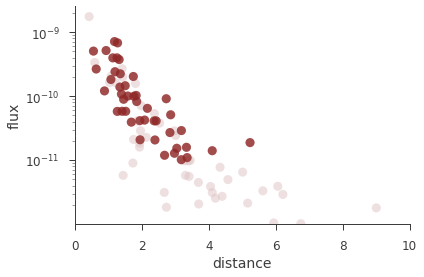

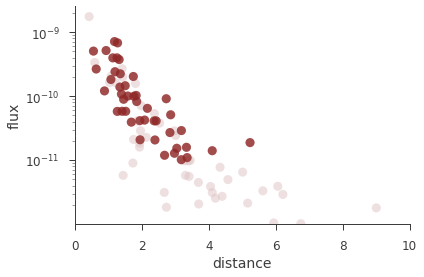

In [5]:
pop_full.display_fluxes()

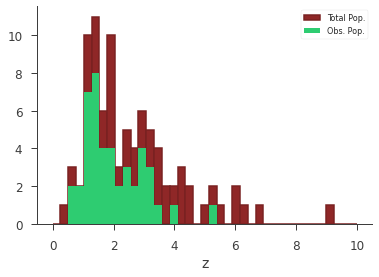

In [6]:
pop_full.display_distances()

### Creating the spectra and its database

We now want to generate observations from Swift-XRT. While we can generate FITS files for each observation. This is a rather bloated file format, so we can store all the data directly to an HDF5 file which can easily translate this data into 3ML plugins as needed. First we load up the spectrum factory.

In [7]:
from whimstan import SpectrumFactory

In [8]:
spec_fac = SpectrumFactory(pop, whim_n0=1e-7, whim_T=1e6, n_jobs=2)

Calculating the simulated datasets:   0%|          | 0/44 [00:00<?, ?it/s]

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available


[WARNING ] The ebltable package is not available. Models that depend on it will not be available


[INFO    ] Starting 3ML!
[WARNING ] no display variable set. using backend for graphics without display (agg)
[WARNING ] ROOT minimizer not available
[WARNING ] Multinest minimizer not available
[INFO    ] Starting 3ML!
[WARNING ] no display variable set. using backend for graphics without display (agg)
[WARNING ] ROOT minimizer not available
[WARNING ] Multinest minimizer not available


[WARNING ] PyGMO is not available
[WARNING ] PyGMO is not available
[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)
[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)
[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?


[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] No fermitools installed


[WARNING ] No fermitools installed


Now we can write this to a file.

In [9]:
spec_fac.create_database("data.h5")

Reading GRBs:   0%|          | 0/44 [00:00<?, ?it/s]

To see how we can work with a database, have a look at the [Working with data]() section.
